# Generate simulation data for fSIM speckle

In [76]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft2, ifft2, fftshift, ifftshift

from IPython import display
import time
import pickle


%matplotlib inline

In [2]:
# Experimental parameters

lambda_f = 0.605           # fluorescence wavelength
mag = 20                   # system magnification
pscrop = 6.5/mag           # effective pixel size on camera plane
upsamp_factor = 1          # upsampling factor (should upsample to Nyquist of expected resolution)
NA_obj = 0.1               # Objective NA
NAs = 0.4                  # Speckle illumination NA
sp_factor = 4              # The ratio of size of the created speckle and the sample
N_bound_pad = 40           # Simulation for non-periodic boundary condition

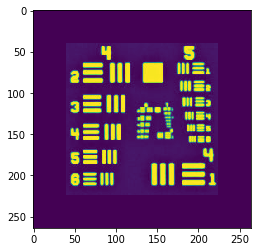

In [3]:
# Load simulation image

I = np.double(plt.imread('resolution.jpg'))
I = I[322:506,357:541,1]
I = np.pad(I/np.max(I),N_bound_pad,mode='constant')

plt.imshow(I)


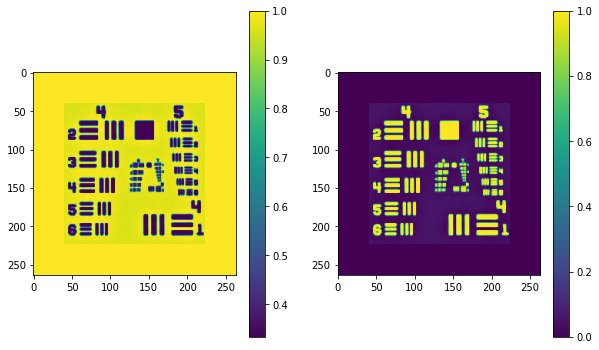

In [4]:
# Setup sample's transmittance function

amp = (1-I)+0.5
amp = amp/np.max(amp)
ph = I.copy()

T_c = amp * np.exp(1j*ph)

fig,ax = plt.subplots(1,2,figsize=(10,6))
ax0 = ax[0].imshow(abs(T_c))
ax1 = ax[1].imshow(np.angle(T_c))
fig.colorbar(ax0,ax=ax[0])
fig.colorbar(ax1,ax=ax[1])


In [52]:
ps = pscrop/upsamp_factor
N, M = I.shape

Ncrop = N//upsamp_factor
Mcrop = M//upsamp_factor

# sample coordiante

x = np.r_[-M/2:M/2]*ps
y = np.r_[-N/2:N/2]*ps

fx = np.r_[-M/2:M/2]/ps/M
fy = np.r_[-N/2:N/2]/ps/N

NAx = fx*lambda_f
NAy = fy*lambda_f

fxx, fyy = np.meshgrid(fx,fy)

fxx = ifftshift(fxx)
fyy = ifftshift(fyy)

fr = (fxx**2 + fyy**2)**(1/2)

# speckle coordinate

xs = np.r_[-M*sp_factor/2:M*sp_factor/2]*ps
ys = np.r_[-N*sp_factor/2:N*sp_factor/2]*ps

fxs = np.r_[-M*sp_factor/2:M*sp_factor/2]/ps/M/sp_factor
fys = np.r_[-N*sp_factor/2:N*sp_factor/2]/ps/N/sp_factor

NAxs = fxs*lambda_f
NAys = fys*lambda_f

fxxs, fyys = np.meshgrid(fxs,fys)

fxxs = ifftshift(fxxs)
fyys = ifftshift(fyys)

frs = (fxxs**2 + fyys**2)**(1/2)


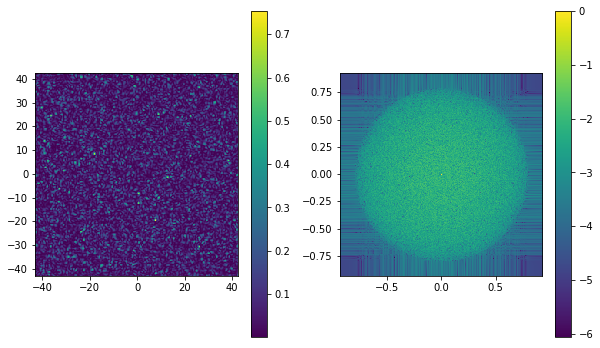

In [6]:
# Speckle field generation

Pupil_s = np.zeros((N*sp_factor,M*sp_factor))
Pupil_s[frs<NAs/lambda_f] = 1

random_phase = np.exp(1j*np.random.rand(N*sp_factor,M*sp_factor)*100)
speckle_field = ifft2(Pupil_s * random_phase)
speckle_field = speckle_field / np.max(abs(speckle_field))
speckle_intensity = abs(speckle_field)**2
speckle_intensity_crop = speckle_intensity[N*sp_factor//2-N//2:N*sp_factor//2+N//2,\
                                           M*sp_factor//2-M//2:M*sp_factor//2+M//2]
speckle_intensity_crop_f = fft2(speckle_intensity_crop)

fig,ax = plt.subplots(1,2,figsize=(10,6))
ax0 = ax[0].imshow(speckle_intensity_crop, extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
ax1 = ax[1].imshow(fftshift(np.log10(abs(speckle_intensity_crop_f)/np.max(abs(speckle_intensity_crop_f)))), \
                   extent=(np.min(NAxs), np.max(NAxs), np.min(NAys), np.max(NAys)))
fig.colorbar(ax0,ax=ax[0])
fig.colorbar(ax1,ax=ax[1])

In [35]:
# Specify speckle scanning trajectory

N_shiftx = 24           # number of x translation
N_shifty = 25           # number of y translation
pixel_step = 2          # number of pixels per translation

Nimg = N_shiftx * N_shifty

pixel_shift_stack = np.zeros((2, Nimg),dtype='int')

if np.mod(N_shiftx,2) == 1:
    pixel_shiftx = np.r_[0:N_shiftx]-(N_shiftx-1)/2
else:
    pixel_shiftx = np.r_[0:N_shiftx]-N_shiftx/2


if np.mod(N_shifty,2) == 1:
    pixel_shifty = np.r_[0:N_shifty]-(N_shifty-1)/2
else:
    pixel_shifty = np.r_[0:N_shifty]-N_shifty/2

    
pixel_shiftxx, pixel_shiftyy = np.meshgrid(pixel_shiftx,pixel_shifty)
pixel_shift_stack[0] = pixel_shiftyy.flatten()
pixel_shift_stack[1] = pixel_shiftxx.flatten()

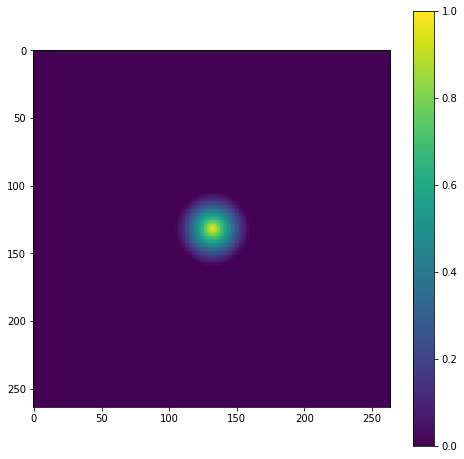

In [8]:
# Transfer function creation

Pupil_obj = np.zeros_like(I)
Pupil_obj[fr<NA_obj/lambda_f] = 1
T_incoherent = abs(fft2(abs(ifft2(Pupil_obj))**2))
T_incoherent = T_incoherent/np.max(T_incoherent)

plt.figure(figsize=(8,8))
plt.imshow(fftshift(T_incoherent))
plt.colorbar()


In [71]:
# Data generation 

Nb = np.int(Ncrop - 2*N_bound_pad/upsamp_factor)
Mb = np.int(Mcrop - 2*N_bound_pad/upsamp_factor)

speckle_intensity_shift_crop = np.zeros((Nimg,N,M))
speckle_field_shift_crop = np.zeros_like(speckle_intensity_shift_crop,dtype=complex)

I_image = np.zeros((Nimg,Nb,Mb))
Ic_image = np.zeros((Nimg,Nb,Mb))

for i in range(0,Nimg):
    speckle_intensity_shift_crop[i] = speckle_intensity[N*sp_factor//2-N//2+pixel_shift_stack[0,i]:\
                                                        N*sp_factor//2+N//2+pixel_shift_stack[0,i],\
                                                        M*sp_factor//2-M//2+pixel_shift_stack[1,i]:\
                                                        M*sp_factor//2+M//2+pixel_shift_stack[1,i]]
    speckle_field_shift_crop[i] = speckle_field[N*sp_factor//2-N//2+pixel_shift_stack[0,i]:\
                                                        N*sp_factor//2+N//2+pixel_shift_stack[0,i],\
                                                        M*sp_factor//2-M//2+pixel_shift_stack[1,i]:\
                                                        M*sp_factor//2+M//2+pixel_shift_stack[1,i]]
    
    Itempf = fftshift(fft2(ifftshift(speckle_intensity_shift_crop[i] * I)) * T_incoherent)
    Itemp = abs(fftshift(ifft2(ifftshift(Itempf[N//2-Ncrop//2:N//2+Ncrop//2,M//2-Mcrop//2:M//2+Mcrop//2]))))
    I_image[i] = Itemp[N_bound_pad//upsamp_factor:N_bound_pad//upsamp_factor+Nb,\
                      N_bound_pad//upsamp_factor:N_bound_pad//upsamp_factor+Mb]
    
    Ic_tempf = fftshift(fft2(ifftshift(speckle_field_shift_crop[i] * T_c)) * Pupil_obj)
    Ic_temp = fftshift(ifft2(ifftshift(Ic_tempf[N//2-Ncrop//2:N//2+Ncrop//2,M//2-Mcrop//2:M//2+Mcrop//2])))
    Ic_image[i] = abs(Ic_temp[N_bound_pad//upsamp_factor:N_bound_pad//upsamp_factor+Nb,\
                      N_bound_pad//upsamp_factor:N_bound_pad//upsamp_factor+Mb])**2
    
    if np.mod(i+1,100) == 0 or i+1 == Nimg:
        print('Data generating process (%d / %d)'%(i+1,Nimg))



Data generating process (100 / 600)
Data generating process (200 / 600)
Data generating process (300 / 600)
Data generating process (400 / 600)
Data generating process (500 / 600)
Data generating process (600 / 600)


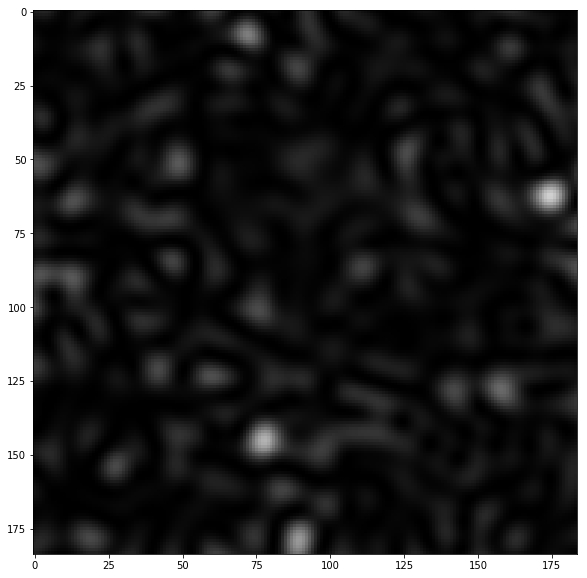

In [74]:
# Animate the image to check the simulated images

f1,ax = plt.subplots(1,1,figsize=(10,10));
max_val = np.max(Ic_image)

for i in range(0,40):
    if i != 1:
        ax.cla()
    ax.imshow(Ic_image[i],cmap='gray',vmin=0,vmax=max_val);
    display.display(f1);
    display.clear_output(wait=True);
    time.sleep(0.0001);

In [77]:
# Save the simulated dataset

f = open('res_speckle_shift.pckl', 'wb')
pickle.dump((pscrop,lambda_f,NA_obj,I_image,Ic_image,pixel_shift_stack,speckle_intensity_shift_crop), f)
f.close()